In [100]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

In [85]:
root_dir = 'Images_split'
dog_names = [item[7:-1] for item in sorted(glob("Images/*/"))]
for i in range(len(dog_names)):
    os.makedirs(root_dir +'/train' + '/' + dog_names[i])
    os.makedirs(root_dir +'/val' + '/'+ dog_names[i])
    os.makedirs(root_dir +'/test' + '/' +dog_names[i])

In [86]:
src = 'Images'
train_im = []
val_im = []
test_im = []
for i in range(len(dog_names)):
    file_images = os.listdir(src+ "/" + dog_names[i])
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(file_images),
                                                          [int(len(file_images)*0.7), int(len(file_images)*0.85)])
    train_FileNames = [src+'/'+ dog_names[i] + '/' + name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + dog_names[i] + '/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + dog_names[i] + '/' + name for name in test_FileNames.tolist()]
    for name in train_FileNames:
        shutil.copy(name, "Images_split/train"+'/' + dog_names[i])
    for name in val_FileNames:
        shutil.copy(name, "Images_split/val"+'/' + dog_names[i])
    for name in test_FileNames:
        shutil.copy(name, "Images_split/test"+'/' + dog_names[i])
    

In [2]:
# function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 120)
    return dog_files, dog_targets

# train, test, and validation datasets
train_files, train_targets = load_dataset("Images_split/train")
valid_files, valid_targets = load_dataset("Images_split/val")
test_files, test_targets = load_dataset("Images_split/test")

# list of dog names
dog_names = [item[15:-1] for item in sorted(glob("Images_split/train/*/"))]

# statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 120 total dog categories.
There are 20580 total dog images.

There are 14355 training dog images.
There are 3084 validation dog images.
There are 3141 test dog images.


In [101]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, Activation
from keras import applications
#from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [1]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=preprocess_input)

    # build the VGG16 network
    model = InceptionV3(include_top=False, weights='imagenet')
    
    #datagen.flow(train_files, train_targets, batch_size=32)
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, (nb_train_samples // batch_size)+1, use_multiprocessing=True, verbose =1)
    np.save(open('bottleneck_features_train_inc.npy', 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, (nb_validation_samples // batch_size)+1,use_multiprocessing=True, verbose=1 )
    np.save(open('bottleneck_features_validation_inc.npy', 'wb'),
            bottleneck_features_validation)
    
    generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_test = model.predict_generator(
        generator, (nb_test_samples//batch_size)+1, use_multiprocessing=True, verbose=1)
    np.save(open('bottleneck_features_test_inc.npy', 'wb'),
            bottleneck_features_test)


In [102]:
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense 
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt  
import math  
import cv2  

In [103]:
# dimensions of our images.  
img_width, img_height = 224, 224  
   
top_model_weights_path = 'bottleneck_fc_model_resnet.h5'  
train_data_dir = 'Images_split/train'  
validation_data_dir = 'Images_split/val'
test_data_dir = 'Images_split/test'
   
 # number of epochs to train top model  
epochs = 100  
 # batch size used by flow_from_directory and predict_generator  
batch_size = 128

In [88]:
model = applications.ResNet50(include_top=False, weights='imagenet')  

In [89]:
datagen = ImageDataGenerator(rescale=1. / 255)  
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = model.predict_generator(generator, predict_size_train, use_multiprocessing=True, verbose =1)  
   
np.save('bottleneck_features_train_r.npy', bottleneck_features_train) 

Found 14355 images belonging to 120 classes.
113/113 [==============================] - 125s 1s/step


In [90]:
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = model.predict_generator(generator, predict_size_test, use_multiprocessing=True, verbose =1)  
   
np.save('bottleneck_features_test_r.npy', bottleneck_features_test) 

Found 3141 images belonging to 120 classes.
25/25 [==============================] - 30s 1s/step


In [91]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
 # load the bottleneck features saved earlier  
test_data = np.load('bottleneck_features_test_r.npy')  
   
 # get the class lebels for the training data, in the original order  
test_labels = generator_top.classes  
   
 # convert the training labels to categorical vectors  
test_labels = to_categorical(test_labels, num_classes=num_classes)  

Found 3141 images belonging to 120 classes.


In [104]:
train_data.shape

(14355, 7, 7, 2048)

In [93]:
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = model.predict_generator(generator, predict_size_validation, use_multiprocessing=True, verbose =1)  
   
np.save('bottleneck_features_validation_r.npy', bottleneck_features_validation) 

Found 3084 images belonging to 120 classes.
25/25 [==============================] - 28s 1s/step


In [94]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
 # load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train_r.npy')  
   
 # get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
 # convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)  

Found 14355 images belonging to 120 classes.


In [95]:
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation_r.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 3084 images belonging to 120 classes.


In [107]:
train_labels.shape

(14355, 120)

In [108]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
 # load the bottleneck features saved earlier  
train_data_n = np.load('bottleneck_features_train_n.npy')  
   
 # get the class lebels for the training data, in the original order  
train_labels_n = generator_top.classes  
   
 # convert the training labels to categorical vectors  
train_labels_n = to_categorical(train_labels_n, num_classes=num_classes)  

Found 14355 images belonging to 120 classes.


In [109]:
train_labels_n.shape

(14355, 120)

In [110]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
 # load the bottleneck features saved earlier  
test_data_n = np.load('bottleneck_features_test_n.npy')  
   
 # get the class lebels for the training data, in the original order  
test_labels_n = generator_top.classes  
   
 # convert the training labels to categorical vectors  
test_labels_n = to_categorical(test_labels_n, num_classes=num_classes)  

Found 3141 images belonging to 120 classes.


In [111]:
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data_n = np.load('bottleneck_features_validation_n.npy')  
   
validation_labels_n = generator_top.classes  
validation_labels_n = to_categorical(validation_labels_n, num_classes=num_classes)  

Found 3084 images belonging to 120 classes.


In [113]:
train_data_n.shape

(14355, 5, 5, 2048)

In [117]:
resnet_avg_model = Sequential()
resnet_avg_model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
train_resnet = resnet_avg_model.predict(train_data)
valid_resnet = resnet_avg_model.predict(validation_data)
test_resnet  = resnet_avg_model.predict(test_data)

In [120]:
train_data.shape

(14355, 7, 7, 2048)

In [121]:
train_data_n.shape[1:]

(5, 5, 2048)

In [123]:
train_resnet.shape

(14355, 2048)

In [122]:
incep_avg_model = Sequential()
incep_avg_model.add(GlobalAveragePooling2D(input_shape=train_data_n.shape[1:]))
train_incep = incep_avg_model.predict(train_data_n)
valid_incep = incep_avg_model.predict(validation_data_n)
test_incep  = incep_avg_model.predict(test_data_n)

In [124]:
train_incep.shape

(14355, 2048)

In [125]:
train_both = np.concatenate((train_resnet,train_incep), axis=1)
valid_both = np.concatenate((valid_resnet,valid_incep), axis=1)
test_both = np.concatenate((test_resnet,test_incep), axis=1)

In [126]:
train_both.shape

(14355, 4096)

In [192]:
model = Sequential()  
#model.add(GlobalAveragePooling2D(input_shape=train_both.shape[1:]))  
#model.add(Dense(256, input_shape=train_both.shape[1:], activation='relu'))  
model.add(Dropout(0.5, input_shape=train_both.shape[1:]))  
model.add(Dense(num_classes, activation = 'softmax'))  
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_37 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 120)               491640    
Total params: 491,640
Trainable params: 491,640
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import LearningRateScheduler

sd=[]
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = [1,1]

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        sd.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

epochs = 100
learning_rate = 0.01
decay_rate = 5e-6
momentum = 0.9

#model=Sequential()
#model.add(Dense(4, input_dim=2, init='uniform'))
#model.add(Dense(1, init='uniform'))
#sgd = SGD(lr=learning_rate,momentum=momentum, decay=decay_rate, nesterov=False)
#model.compile(loss='mean_squared_error',optimizer=sgd,metrics=['mean_absolute_error'])

def step_decay(losses):
    if float(2*np.sqrt(np.array(history.losses[-1])))<0.3:
        lrate=0.01*1/(1+0.1*len(history.losses))
        #momentum=0.8
        decay_rate=2e-6
        return lrate
    else:
        lrate=0.01
        return lrate
history=LossHistory()
lrate=LearningRateScheduler(step_decay)

model.fit(X_train,y_train,nb_epoch=epochs,callbacks=[history,lrate],verbose=2)
model.predict(X_test)

In [193]:
epochs = 300  
batch_size = 128

opt = Adam(lr=0.00001)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
history = model.fit(train_both, train_labels,  
          epochs=epochs,  
          batch_size=batch_size,  
          validation_data=(valid_both, validation_labels))  

Train on 14355 samples, validate on 3084 samples
Epoch 1/300
14355/14355 [==============================] - 6s 450us/step - loss: 5.6174 - acc: 0.0083 - val_loss: 4.9163 - val_acc: 0.0139
Epoch 2/300
14355/14355 [==============================] - 1s 44us/step - loss: 5.2039 - acc: 0.0170 - val_loss: 4.5839 - val_acc: 0.0392
Epoch 3/300
14355/14355 [==============================] - 1s 46us/step - loss: 4.9051 - acc: 0.0291 - val_loss: 4.3125 - val_acc: 0.0879
Epoch 4/300
14355/14355 [==============================] - 1s 43us/step - loss: 4.6388 - acc: 0.0419 - val_loss: 4.0662 - val_acc: 0.1592
Epoch 5/300
14355/14355 [==============================] - 1s 44us/step - loss: 4.3897 - acc: 0.0653 - val_loss: 3.8331 - val_acc: 0.2383
Epoch 6/300
14355/14355 [==============================] - 1s 44us/step - loss: 4.1764 - acc: 0.0938 - val_loss: 3.6098 - val_acc: 0.3294
Epoch 7/300
14355/14355 [==============================] - 1s 43us/step - loss: 0.4854 - acc: 0.8463 - val_loss: 0.6121 - 

In [194]:
model.save_weights(top_model_weights_path)  
   
(eval_loss, eval_accuracy) = model.evaluate(test_both, test_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  

3141/3141 [==============================] - 0s 27us/step
[INFO] accuracy: 80.26%
[INFO] Loss: 0.671162964004652


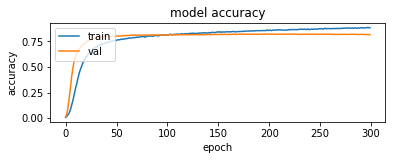

In [197]:
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
   


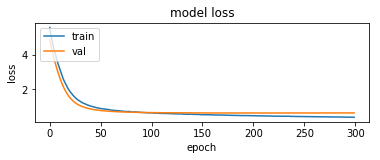

In [198]:
# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()  

In [3]:
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt  
import math  
import cv2  

In [95]:
model = applications.InceptionV3(include_top=False, weights='imagenet')  

In [96]:
datagen = ImageDataGenerator(rescale=1. / 255)  
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = model.predict_generator(generator, predict_size_train, use_multiprocessing=True, verbose =1)  
   
np.save('bottleneck_features_train_n.npy', bottleneck_features_train) 

Found 14355 images belonging to 120 classes.
898/898 [==============================] - 116s 129ms/step


In [97]:
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = model.predict_generator(generator, predict_size_test, use_multiprocessing=True, verbose =1)  
   
np.save('bottleneck_features_test_n.npy', bottleneck_features_test) 

Found 3141 images belonging to 120 classes.
197/197 [==============================] - 23s 118ms/step


In [98]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
 # load the bottleneck features saved earlier  
test_data = np.load('bottleneck_features_test_n.npy')  
   
 # get the class lebels for the training data, in the original order  
test_labels = generator_top.classes  
   
 # convert the training labels to categorical vectors  
test_labels = to_categorical(test_labels, num_classes=num_classes)  

Found 3141 images belonging to 120 classes.


In [99]:
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = model.predict_generator(generator, predict_size_validation, use_multiprocessing=True, verbose =1)  
   
np.save('bottleneck_features_validation_n.npy', bottleneck_features_validation) 

Found 3084 images belonging to 120 classes.
193/193 [==============================] - 23s 117ms/step


In [100]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
 # load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train_n.npy')  
   
 # get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
 # convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)  

Found 14355 images belonging to 120 classes.


In [101]:
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation_n.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 3084 images belonging to 120 classes.


In [151]:
model = Sequential()  
model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))  
model.add(BatchNormalization())
#model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='softmax'))  
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_23  (None, 2048)              0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_24 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 120)               245880    
Total params: 254,072
Trainable params: 249,976
Non-trainable params: 4,096
_________________________________________________________________


In [ ]:
epochs = 20  
#batch_size = 30
from keras.optimizers import SGD, Adam
opt = Adam(lr=0.0001)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
history = model.fit(train_data, train_labels,  
          epochs=epochs,  
          batch_size=batch_size,  
          validation_data=(validation_data, validation_labels))  

In [104]:
model.save_weights(top_model_weights_path)  
   
(eval_loss, eval_accuracy) = model.evaluate(test_data, test_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  

3141/3141 [==============================] - 1s 239us/step
[INFO] accuracy: 78.19%
[INFO] Loss: 0.8511112540438357


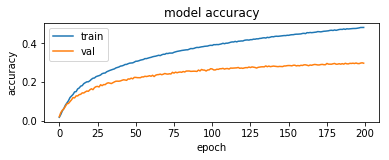

In [92]:
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
   


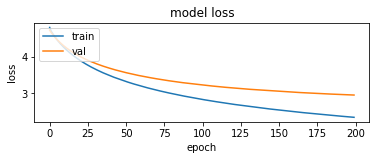

In [93]:
# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()  

In [6]:
# dimensions of our images.  
img_width, img_height = 224, 224  
   
top_model_weights_path = 'bottleneck_fc_model_xception.h5'  
train_data_dir = 'Images_split/train'  
validation_data_dir = 'Images_split/val'
test_data_dir = 'Images_split/test'
   
 # number of epochs to train top model  
#epochs = 50  
 # batch size used by flow_from_directory and predict_generator  
batch_size = 20  

In [4]:
model_x = applications.Xception(include_top=False, weights='imagenet')  

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
datagen = ImageDataGenerator(rescale=1. / 255)  
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = model_x.predict_generator(generator, predict_size_train, use_multiprocessing=True, verbose =1)  
   
np.save('bottleneck_features_train_x.npy', bottleneck_features_train) 

Found 14355 images belonging to 120 classes.
718/718 [==============================] - 199s 277ms/step


In [9]:
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = model_x.predict_generator(generator, predict_size_test, use_multiprocessing=True, verbose =1)  
   
np.save('bottleneck_features_test_x.npy', bottleneck_features_test) 

Found 3141 images belonging to 120 classes.
158/158 [==============================] - 71s 450ms/step


In [10]:
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = model_x.predict_generator(generator, predict_size_validation, use_multiprocessing=True, verbose =1)  
   
np.save('bottleneck_features_validation_x.npy', bottleneck_features_validation) 

Found 3084 images belonging to 120 classes.
155/155 [==============================] - 59s 379ms/step


In [46]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
 # load the bottleneck features saved earlier  
test_data = np.load('bottleneck_features_test_x.npy')  
   
 # get the class lebels for the training data, in the original order  
test_labels = generator_top.classes  
   
 # convert the training labels to categorical vectors  
test_labels = to_categorical(test_labels, num_classes=num_classes)  

Found 3141 images belonging to 120 classes.


In [18]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
 # load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train_x.npy')  
   
 # get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
 # convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)  

Found 14355 images belonging to 120 classes.


In [19]:
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation_x.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 3084 images belonging to 120 classes.


In [179]:
classes = [np.argmax(validation_labels[i]) for i in range(3000)]

In [180]:
def plot_scatter(values, clas):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(-0.5, 1.0, 120))

    # Get the color for each sample.
    colors = cmap[clas]

    # Extract the x- and y-values.
    x = values[:, 0]
    y = values[:, 1]

    # Plot it.
    plt.scatter(x, y, color=colors)
    plt.show()

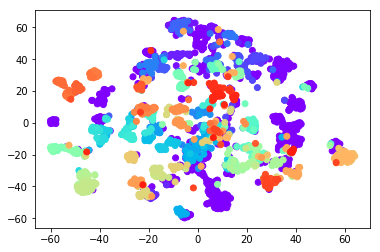

In [181]:
plot_scatter(transfer_values_reduced, classes)

In [82]:
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, Activation
from keras import regularizers
modelx = Sequential()  
modelx.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))  
modelx.add(Dense(128))  
modelx.add(BatchNormalization())
modelx.add(Activation('relu'))
modelx.add(Dropout(0.3))  
modelx.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.001), activation='softmax'))  
modelx.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_18  (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               262272    
_________________________________________________________________
batch_normalization_19 (Batc (None, 128)               512       
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 120)               15480     
Total params: 278,264
Trainable params: 278,008
Non-trainable params: 256
_________________________________________________________________


In [ ]:
epochs = 100  
batch_size = 30
from keras.optimizers import SGD, Adam, Nadam
#opt = Adam(lr=0.0001)
opt = Adam(lr= 0.00001)
modelx.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
history = modelx.fit(train_data, train_labels,  
          epochs=epochs,  
          batch_size=batch_size,  
          validation_data=(validation_data, validation_labels))  

Train on 14355 samples, validate on 3084 samples
Epoch 1/100
14355/14355 [==============================] - 9s 617us/step - loss: 5.0239 - acc: 0.0192 - val_loss: 4.6247 - val_acc: 0.0525
Epoch 2/100
14355/14355 [==============================] - 6s 421us/step - loss: 4.4837 - acc: 0.0703 - val_loss: 4.1180 - val_acc: 0.1981
Epoch 3/100
14355/14355 [==============================] - 6s 416us/step - loss: 4.0345 - acc: 0.1740 - val_loss: 3.7018 - val_acc: 0.3680
Epoch 4/100
14355/14355 [==============================] - 6s 425us/step - loss: 3.6639 - acc: 0.3012 - val_loss: 3.3689 - val_acc: 0.4958
Epoch 5/100
14355/14355 [==============================] - 6s 433us/step - loss: 3.3687 - acc: 0.4093 - val_loss: 3.0948 - val_acc: 0.5778
Epoch 6/100
14355/14355 [==============================] - 6s 421us/step - loss: 3.1229 - acc: 0.4881 - val_loss: 2.8787 - val_acc: 0.6265
Epoch 7/100
14355/14355 [==============================] - 6s 436us/step - loss: 1.5753 - acc: 0.7617 - val_loss: 1.4

In [80]:
modelx.save_weights(top_model_weights_path)  
   
(eval_loss, eval_accuracy) = modelx.evaluate(test_data, test_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  

3141/3141 [==============================] - 1s 318us/step
[INFO] accuracy: 78.03%
[INFO] Loss: 1.033141862156284


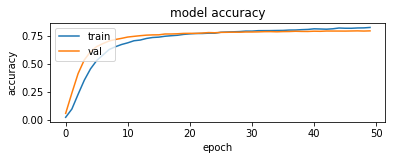

In [81]:
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
   


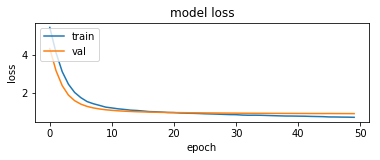

In [72]:
# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()  

In [ ]:
inID = class_predicted[0]  
   
class_dictionary = generator_top.class_indices  
   
inv_map = {v: k for k, v in class_dictionary.items()}  
   
label = inv_map[inID]  
   
 # get the prediction label  
print("Image ID: {}, Label: {}".format(inID, label))  
   
 # display the predictions with the image  
cv2.putText(orig, "Predicted: {}".format(label), (10, 30), cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)  
   
cv2.imshow("Classification", orig)  
cv2.waitKey(0)  
cv2.destroyAllWindows()  